# 2020.08.06 AIFFEL LMS Exploration 4 Project
   
   * 이미지 분류기 만들기

Step 1. 데이터셋 내려받기

 - tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용
 - tfds.load를 활용하여 데이터셋을 다운 받을 것

In [1]:
# 버전 문제로 인한 경고 무시를 위한 코드
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 텐서플로우 데이터 셋 호출 및 버전 확인

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

In [3]:
# 데이터 변수 저장

# train 데이터와 validation 데이터, test데이터를각각 80:10:10 비율로 분리 

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
# 데이터 타입 확인

print(raw_train)
print(raw_validation)
print(raw_test)

print(type(raw_train))
print(type(raw_validation))
print(type(raw_test))

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


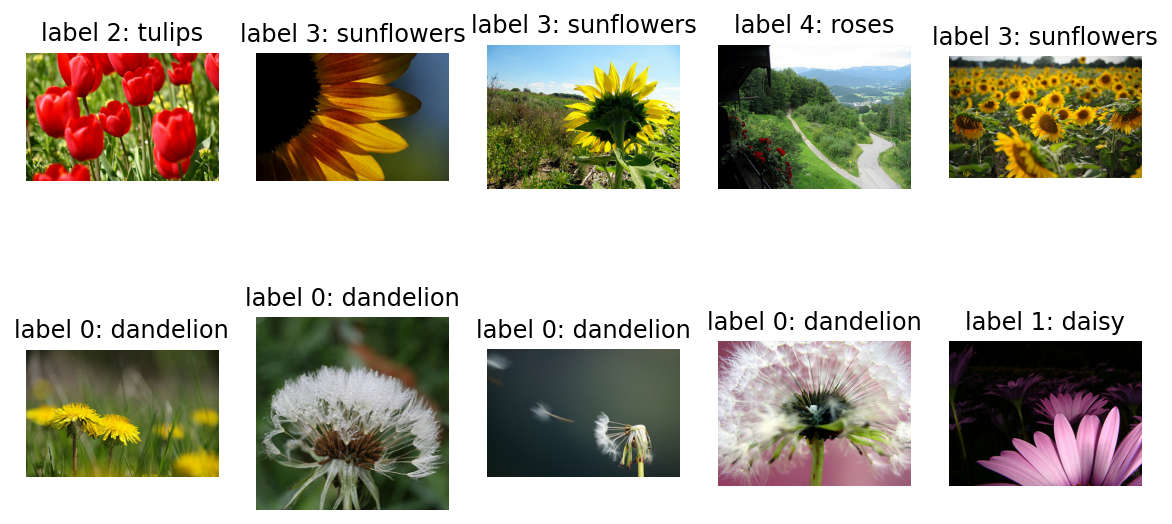

In [5]:
# 데이터 시각화 및 확인

#라이브러리 호출
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str
 
# take(10) : 10개 만큼 데이터를 추출하여 새로운 데이터셋 인스턴스를 만듬 
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

 - 이미지를 모두 같은 크기로 formatting 한 후, 
 - train_batches, validation_batches, test_batches를 준비

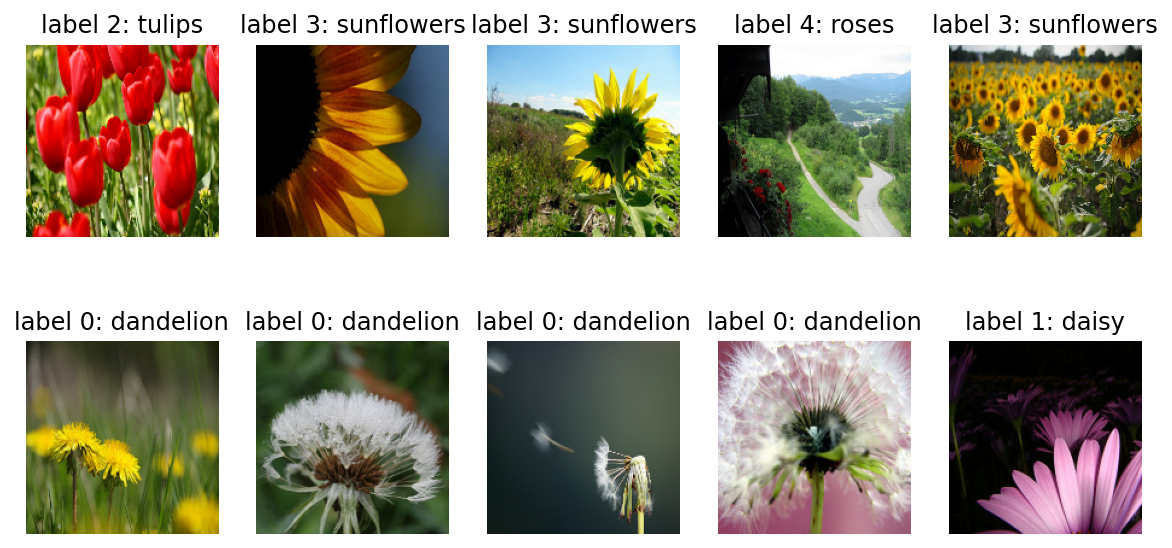

In [6]:
# 모든 이미지를 동일한 사이즈 160*160으로 변경

IMG_SIZE = 160

# 이미지 사이즈 변경 함수 정의
def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    

    image = (image/127.5) - 1
    # image 데이터의 픽셀은 0~255 사이의 값이며,
    # 그들의 중간 값인 127.5로 나누고 1을 뺐으므로,
    # -1~1 사이의 실수 값으로 변경됨
    
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# 이미지 사이즈 변경 수행
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 사이즈 변경 된 이미지 출력 및 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [7]:
# 모델을 학습시킬 데이터를 준비

# BATCH_SIZE : 한 스텝에 학습시킬 데이터의 개수 = 32개
# 전체 데이터 셋에서 32개씩 묶어서 한 batch로 정하고 학습
BATCH_SIZE = 32

# SHUFFLE_BUFFER_SIZE : 학습 데이터를 적절히 섞어줄 버퍼의 크기 설정
# 데이터 셋은 버퍼 라는 공간에 담겨져 순서가 랜덤하게 섞이는데, 그 버퍼의 크기
# 데이터가 완벽하게 섞이기 위해서는 버퍼의 크기거 전체 데이터셋의 크기보다 크거나 같아야 한다.
SHUFFLE_BUFFER_SIZE = 10000

# 전체 데이터에서 32개를 랜덤으로 뽑아 제공
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Step 3. 모델 설계하기

 -  tf_flowers 데이터셋에서는 class의 갯수가 5가지임에 유의

In [8]:
# 모델 설계

# 라이브러리 호출
# .models : 모델 그 자체를 구축하기 위한 함수들을 포함
# Sequential은 연속적인 모델을 쌓기 위한 함수
from tensorflow.keras.models import Sequential

# .layers : 모델의 구성 요소인 여러가지 종류의 레이어(layers), 
# 즉 "층" 이라는 함수를 가지고 있음
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Conv2D, MaxPooling2D, Flatten, Dense 라는 네 가지 종류의 레이어를 사용한 모델

model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    
    # 아래 Dense(units=5가 Class 5개임을 설정해 주는 부분
    Dense(units=5, activation='softmax')
])

model.summary()
# summary() 메소드는 모델의 전체 구조를 한눈에 보여줌

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [9]:
# 모델 학습률 조정

# - "학습률"(learning_rate)이라는 파라미터를 0.0001으로 설정
# - 모델을 compile 하여 학습할 수 있는 형태로 변환
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# - **`optimizer`**
#     - 학습을 어떤 방식으로 시킬 것인지 결정
#     - 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부름
# - **`loss`**
#     - 모델이 학습해나가야 하는 방향을 결정
#     - 이 문제에서는 모델의 출력은 입력받은 이미지가 고양이인지 강아지인지에 대한 확률분포로 두었으므로, 입력이미지가 고양이(label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에 가깝도록 하는 방향을 제시
# - **`metrics`**
#     - 모델의 성능을 평가하는 척도
#     - 분류 문제를 풀 때, 성능을 평가할 수 있는 지표
#     - 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있음

Step 4. 모델 학습

 - 여기에서는 여러 가지 옵션을 바꿔볼 수 있음
 - 예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나,
 - learning_rate 값을 바꿔볼 수 있음
 - 또는, optimizer의 종류도 바꿔볼 수 있음
 - VGG16이 아닌 다른 모델을 base model로 활용할 수도 있음
 - 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수도 있음
 - Dropout이나 Batch Normalization을 적용하는 등 Regularization 기법이 적용

In [10]:
# 학습 전 초기 모델 성능 확인 
# Validation batch에서 20번 예측 후, 평균 loss와 평균 정확도 확인
validation_steps = 10
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 0s 34ms/step - loss: 1.6757 - accuracy: 0.1406
initial loss: 1.68
initial accuracy: 0.14


In [11]:
# 10번 트레이닝 학습(10~20분 소요)
# Validation_batches를 이용한 검증

EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 31s 338ms/step - loss: 1.3720 - accuracy: 0.4169 - val_loss: 1.1370 - val_accuracy: 0.4959
Epoch 2/10
92/92 [==============================] - 8s 92ms/step - loss: 1.0313 - accuracy: 0.5797 - val_loss: 1.0403 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 9s 96ms/step - loss: 0.8804 - accuracy: 0.6580 - val_loss: 0.9396 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 8s 89ms/step - loss: 0.7480 - accuracy: 0.7153 - val_loss: 1.0976 - val_accuracy: 0.5722
Epoch 5/10
92/92 [==============================] - 9s 93ms/step - loss: 0.6180 - accuracy: 0.7704 - val_loss: 1.0958 - val_accuracy: 0.5668
Epoch 6/10
92/92 [==============================] - 8s 92ms/step - loss: 0.5322 - accuracy: 0.8099 - val_loss: 0.9297 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 8s 89ms/step - loss: 0.4332 - accuracy: 0.8532 - val_loss: 0.8982 - val_accuracy: 0.6540
Epoch 8/10


Step 5. 모델 성능 평가하기

 - 모델이 학습된 과정을 그래프로도 그려보고, 
 - validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 볼 것


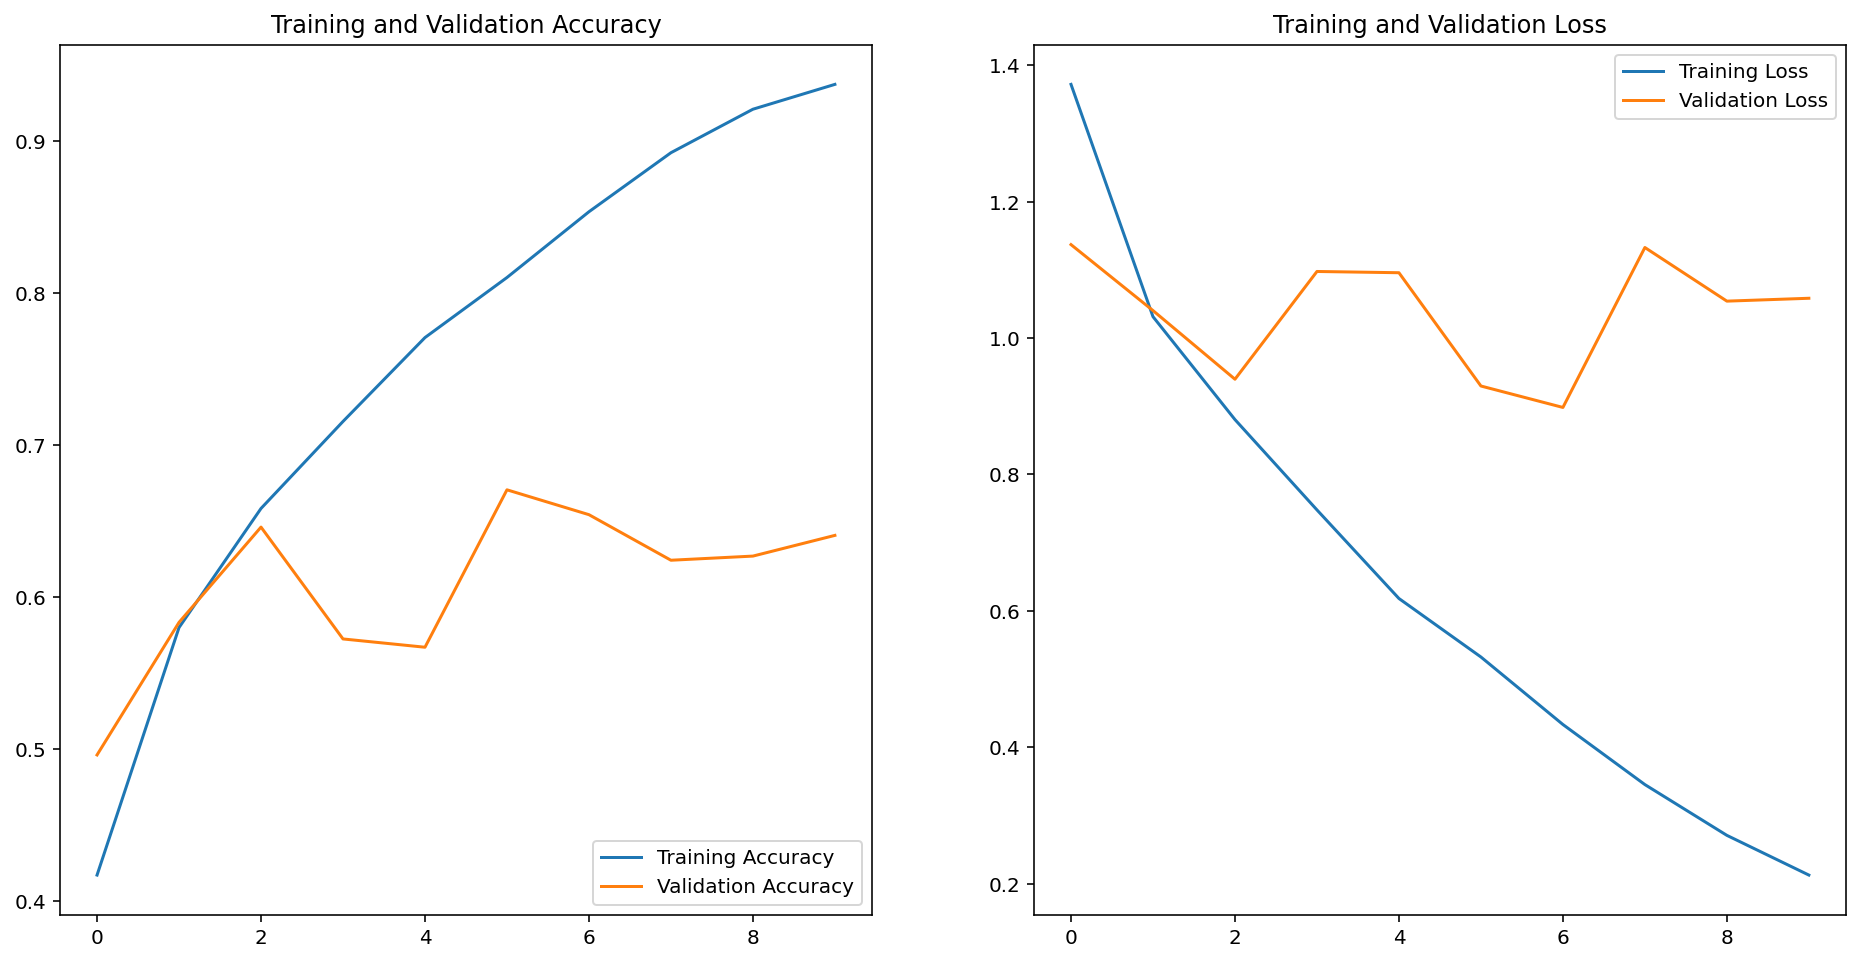

In [12]:
# 모델 학습 과정에 대한 그래프

# 첫 번째 accuracy는 훈련 데이터셋에 대한 정확도
# 학습하고 있는 데이터에 대한 정확도

# 두 번째 val_accuracy는 검증 데이터셋에 대한 정확도
# 학습하지 않고 있는, 즉 해당 학습 단계에서 보지 않은 데이터에 대한 정확도

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# 10번 트레이닝 학습(10~20분 소요)
# test_batches를 이용한 검증

EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches)

Epoch 1/10
92/92 [==============================] - 11s 117ms/step - loss: 0.1506 - accuracy: 0.9625 - val_loss: 0.9679 - val_accuracy: 0.6812
Epoch 2/10
92/92 [==============================] - 10s 109ms/step - loss: 0.1219 - accuracy: 0.9680 - val_loss: 1.1216 - val_accuracy: 0.6403
Epoch 3/10
92/92 [==============================] - 10s 105ms/step - loss: 0.0898 - accuracy: 0.9765 - val_loss: 1.1179 - val_accuracy: 0.6703
Epoch 4/10
92/92 [==============================] - 11s 122ms/step - loss: 0.0694 - accuracy: 0.9833 - val_loss: 1.1627 - val_accuracy: 0.6730
Epoch 5/10
92/92 [==============================] - 9s 96ms/step - loss: 0.0662 - accuracy: 0.9874 - val_loss: 1.6298 - val_accuracy: 0.5886
Epoch 6/10
92/92 [==============================] - 8s 91ms/step - loss: 0.0378 - accuracy: 0.9908 - val_loss: 2.2503 - val_accuracy: 0.5531
Epoch 7/10
92/92 [==============================] - 8s 90ms/step - loss: 0.0444 - accuracy: 0.9898 - val_loss: 1.3375 - val_accuracy: 0.6621
Epoch

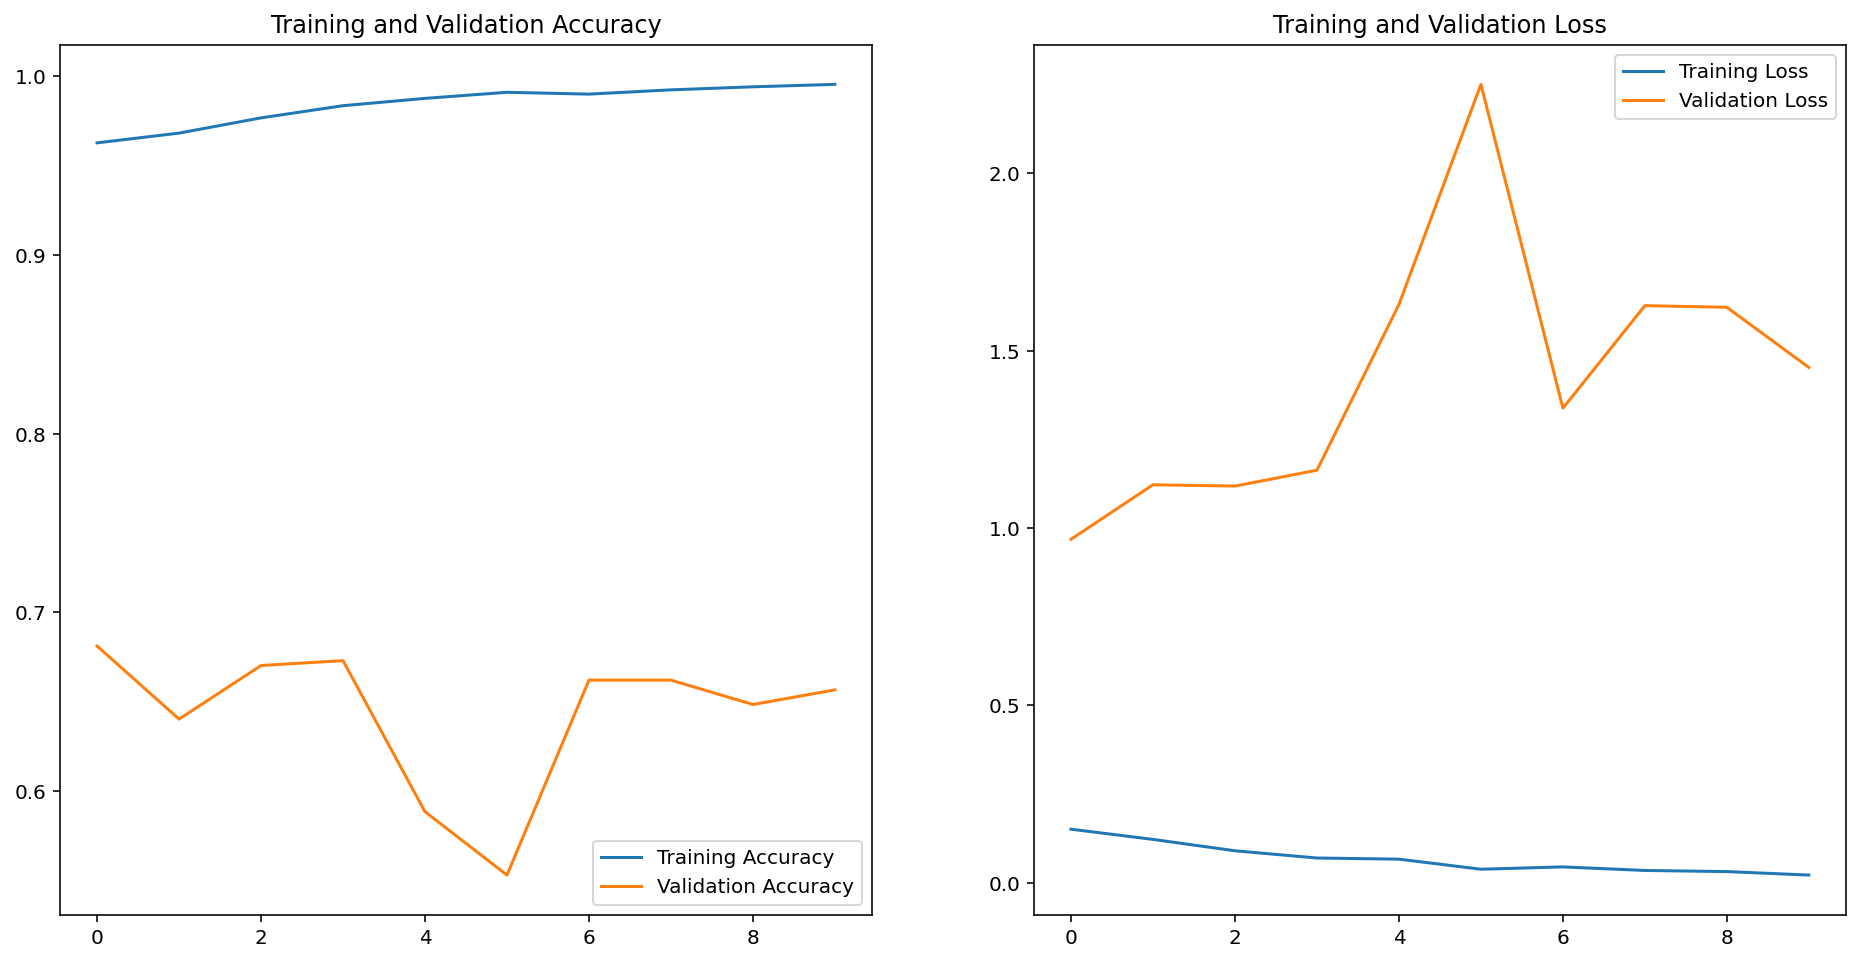

In [14]:
# 모델 학습 과정에 대한 그래프(test_batches를 활용한 검증)

# 첫 번째 accuracy는 훈련 데이터셋에 대한 정확도
# 학습하고 있는 데이터에 대한 정확도

# 두 번째 val_accuracy는 검증 데이터셋에 대한 정확도
# 학습하지 않고 있는, 즉 해당 학습 단계에서 보지 않은 데이터에 대한 정확도

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Step 6. 모델 활용하기

 - 원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해보기

In [15]:
# 경로 설정을 위한 라이브러리 호출
import os

# 분류할 이미지의 경로를 변수에 저장
img_dir_path = os.getenv("HOME") + "/aiffel/flower_classifier/images"
os.path.exists(img_dir_path)

True

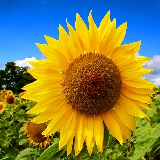

In [16]:
# 분류할 이미지를 모델 입력 사이즈에 맞게 전처리

# 이미지 전처리 라이브러리 호출
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 전처리 이미지 경로 설정
choco_image_path = os.path.join(img_dir_path, 'choco.png')

# 이미지의 사이즈를 변환하여 변수에 저장
IMG_SIZE = 160
choco_image = load_img(choco_image_path, target_size=(IMG_SIZE, IMG_SIZE))
choco_image

In [17]:
# 이미지 데이터의 행렬 사이즈를 모델 함수에 입력 할 수 있도록 변환
choco_image = img_to_array(choco_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
choco_image.shape

(1, 160, 160, 3)

In [20]:
# 모델을 이용하여 이미지 예측 분류


import numpy as np

prediction = model.predict(choco_image)

prediction

# lable : 0=민들레, 1=데이지, 2=튤립, 3=해바라기, 4=장미

array([[0., 0., 0., 1., 0.]], dtype=float32)

In [22]:
# 예측 값을 받아 결과를 출력하는 함수 정의 및 실행

def show_and_predict_image(prediction):
    

    for i in range(5):
        if prediction[0][i] == 1:
            if i == 0:
                print("This is dandelion")
            elif i == 1:
                print("This is daisy")
            elif i == 2:
                print("This is tulips")
            elif i == 3:
                print("This is sunflowers")
            else :
                print("This is roses")



show_and_predict_image(prediction)

This is sunflowers


# 결과

- 마지막 결과로 해바라기 사진을 잘 분류 하였으므로, 어느 정도 분류기가 성능을 내는 것은 
  확인 할수 있었습니다.
- 하지만 validation Data 기준으로 측정한 정확도가 65% 인것에 대해서는 분류기의 성능이 많이 좋지 않은 것을 확인 할 수 있었습니다.
- 아직 딥러닝에 대한 이론 학습을 하기전에 미리 실습을 해본 것 이므로, 추후 CS231n과 LMS Fundamental 수업의 딥러닝 파트를 수강 후, 각 레이어의 특성과 파라미터의 의미를 이해 한 후, 값을 변경해가며 모델을 최적화 시킨다면, 분류기의 정확도가 향상 될 것으로 생각 됩니다.

- 마지막 결과 도출 함수에 대해서는 이미지를 불러와 전처리하고 예측하는 과정이 중복되어 있어서 제거하고 간단하게 출력하도록 변경 하였습니다.